# Simple FbProphet

This code template is for Time Series Analysis and Forecasting to make scientific predictions based on historical time stamped data with the help of FbProphet algorithm

### Required Packages

In [ ]:
!pip install fbprophet

In [181]:
import warnings 
import numpy as np
import pandas as pd 
import seaborn as se 
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error 
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.diagnostics import performance_metrics

warnings.filterwarnings("ignore")


### Initialization

Filepath of CSV file

In [182]:
file_path = ""

Variable containing the date time column name of the Time Series data

In [183]:
date = ""

Target feature for prediction.

In [184]:
target = ""

### Data Fetching

Pandas is an open-source, BSD-licensed library providing high-performance, easy-to-use data manipulation and data analysis tools.

We will use panda's library to read the CSV file using its storage path.And we use the head function to display the initial row or entry.

In [196]:
df = pd.read_csv(file_path)
df.head()

DATE  IPG2211A2N
0  1/1/1985     72.5052
1  2/1/1985     70.6720
2  3/1/1985     62.4502
3  4/1/1985     57.4714
4  5/1/1985     55.3151

### Data Preprocessing

Since the majority of the machine learning models for Time Series Forecasting doesn't handle string category data and Null value, we have to explicitly remove or replace null values. The below snippets have functions, which removes the rows containing null value if any exists. And convert the string classes date column in the datasets to proper Date-time classes.

After the proper date conversions are done and null values are dropped, we set the Date column as the index value.


In [197]:
def data_preprocess(df, target, date):
    df = df.dropna(axis=0, how = 'any')
    df[date] = pd.to_datetime(df[date])
    df = df.set_index(date)
    return df

In [198]:
df = data_preprocess(df,target,date)
df.head()

IPG2211A2N
DATE                  
1985-01-01     72.5052
1985-02-01     70.6720
1985-03-01     62.4502
1985-04-01     57.4714
1985-05-01     55.3151

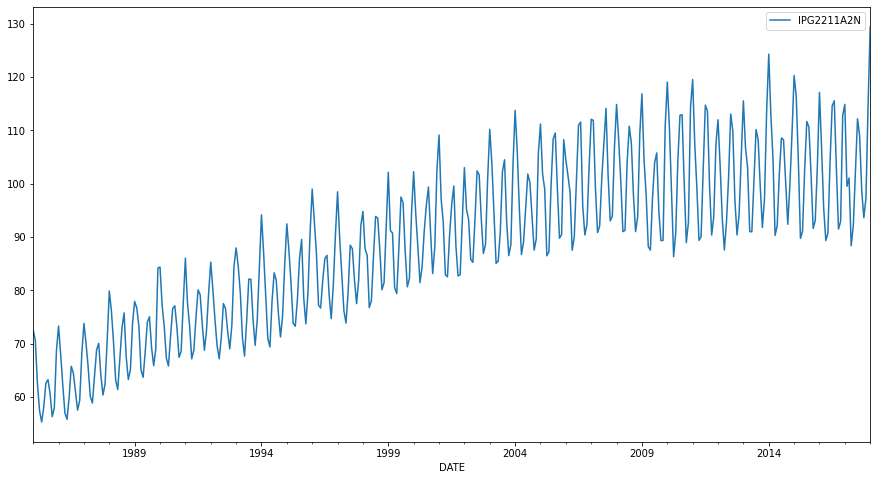

In [199]:
df.plot(figsize = (15,8))
plt.show()

# Converting Data in Appropriate form

In [200]:
def convert_index(df):
  df = df.reset_index()
  df.columns = ["ds","y"]
  return df

### Autocorrelation Plot


We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.
A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function, or the acronym ACF. 

An autocorrelation plot shows whether the elements of a time series are positively correlated, negatively correlated, or independent of each other. 
The plot shows the value of the autocorrelation function (acf) on the vertical axis ranging from –1 to 1.
There are vertical lines (a “spike”) corresponding to each lag and the height of each spike shows the value of the autocorrelation function for the lag.

[API](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)

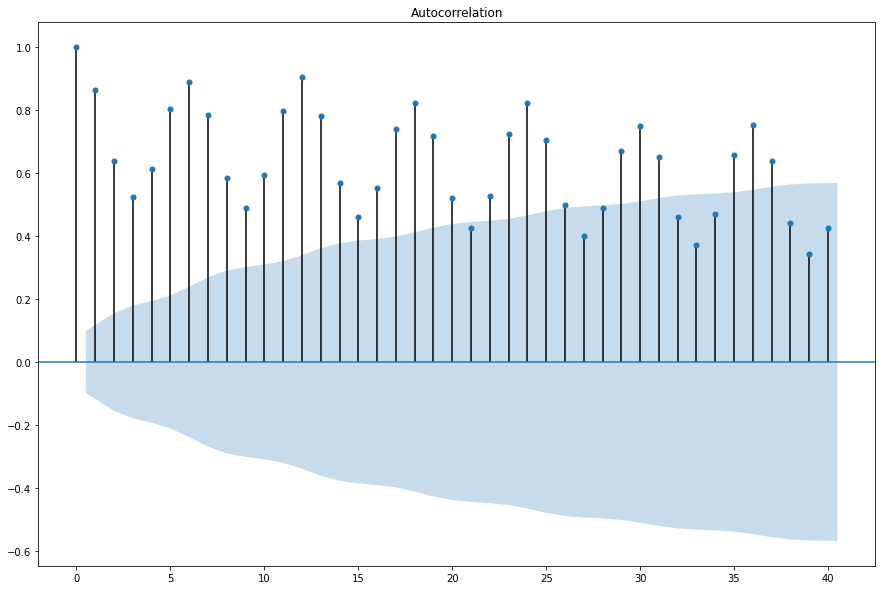

In [201]:
x = plot_acf(df, lags=40)
x.set_size_inches(15, 10, forward=True)
plt.show()

### Partial Autocorrelation Plot

A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags. By examining the spikes at each lag we can determine whether they are significant or not. A significant spike will extend beyond the significant limits, which indicates that the correlation for that lag doesn't equal zero.

[API](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html)


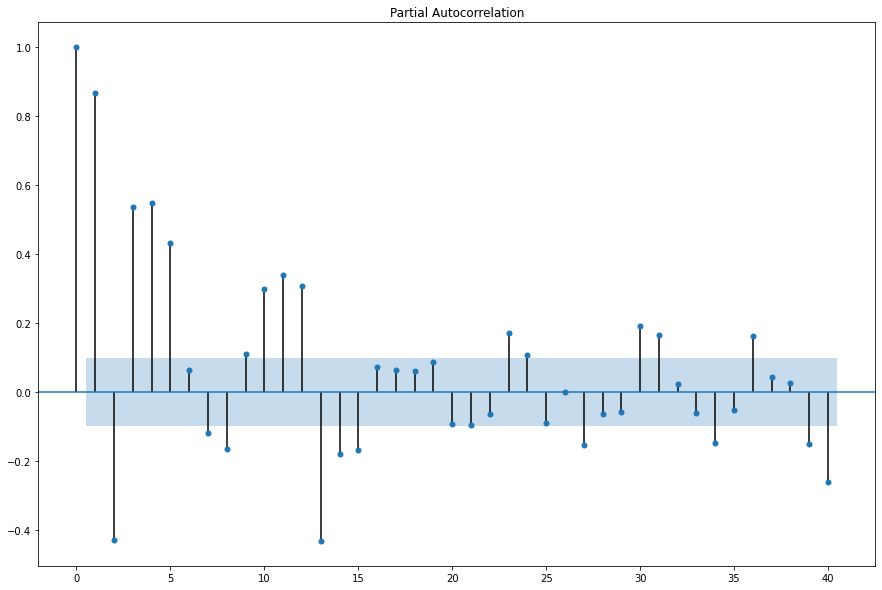

In [202]:
y = plot_pacf(df, lags=40)
y.set_size_inches(15, 10, forward=True)
plt.show()

In [203]:
df = convert_index(df)
df.head()

ds        y
0 1985-01-01  72.5052
1 1985-02-01  70.6720
2 1985-03-01  62.4502
3 1985-04-01  57.4714
4 1985-05-01  55.3151

### Data Splitting

Since we are using a univariate dataset, we can directly split our data into training and testing subsets. The first subset is utilized to fit/train the model. The second subset is used for prediction. The main motive is to estimate the performance of the model on new data.

In [204]:
size = int(len(df)*0.9)
df_train, df_test = df.iloc[:size], df.iloc[size:]

### Model

Prophet follows the sklearn model API. We create an instance of the Prophet class and then call its fit and predict methods.

The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.


[For More Reference](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) 

In [205]:
model = Prophet()
result = model.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


# Finding future dates using Model

In [206]:
future_dates = model.make_future_dataframe(periods=365)
future_dates

ds
0   1985-01-01
1   1985-02-01
2   1985-03-01
3   1985-04-01
4   1985-05-01
..         ...
757 2018-12-28
758 2018-12-29
759 2018-12-30
760 2018-12-31
761 2019-01-01

[762 rows x 1 columns]

#### Simple Forecasting

In [152]:
df_train.tail()

ds         y
352 2014-05-01   92.1340
353 2014-06-01  101.8780
354 2014-07-01  108.5497
355 2014-08-01  108.1940
356 2014-09-01  100.4172

### Predictions

By specifying the start and end time for our predictions, we can easily predict the future points in our time series with the help of our model.

In [170]:
predicted = result.predict(df_test)
predicted

ds       trend  ...  multiplicative_terms_upper        yhat
0  2014-10-01  102.929419  ...                         0.0   93.727831
1  2014-11-01  102.953351  ...                         0.0   96.499535
2  2014-12-01  102.976511  ...                         0.0  108.596870
3  2015-01-01  103.000443  ...                         0.0  116.229509
4  2015-02-01  103.024375  ...                         0.0  108.869045
5  2015-03-01  103.045991  ...                         0.0  102.745383
6  2015-04-01  103.069923  ...                         0.0   93.032292
7  2015-05-01  103.093083  ...                         0.0   93.051350
8  2015-06-01  103.117014  ...                         0.0  101.080743
9  2015-07-01  103.140174  ...                         0.0  109.046162
10 2015-08-01  103.164106  ...                         0.0  109.786574
11 2015-09-01  103.188038  ...                         0.0  100.643185
12 2015-10-01  103.211198  ...                         0.0   94.059034
13 2015-11-01  103.235130  ...                         0.0   96.684985
14 2015-12-01  103.258290  ...                         0.0  107.953798
15 2016-01-01  103.282222  ...                         0.0  116.650103
16 2016-02-01  103.306154  ...                         0.0  109.784548
17 2016-03-01  103.328541  ...                         0.0  102.051130
18 2016-04-01  103.352473  ...                         0.0   94.043511
19 2016-05-01  103.375633  ...                         0.0   94.427181
20 2016-06-01  103.399565  ...                         0.0  102.241106
21 2016-07-01  103.422725  ...                         0.0  109.179405
22 2016-08-01  103.446657  ...                         0.0  108.721172
23 2016-09-01  103.470589  ...                         0.0  100.306891
24 2016-10-01  103.493749  ...                         0.0   94.170030
25 2016-11-01  103.517681  ...                         0.0   97.221411
26 2016-12-01  103.540840  ...                         0.0  111.027994
27 2017-01-01  103.564772  ...                         0.0  116.579752
28 2017-02-01  103.588704  ...                         0.0  108.188651
29 2017-03-01  103.610320  ...                         0.0  102.673663
30 2017-04-01  103.634252  ...                         0.0   94.094677
31 2017-05-01  103.657412  ...                         0.0   94.343801
32 2017-06-01  103.681344  ...                         0.0  102.221316
33 2017-07-01  103.704504  ...                         0.0  109.499453
34 2017-08-01  103.728436  ...                         0.0  109.450427
35 2017-09-01  103.752367  ...                         0.0  100.801218
36 2017-10-01  103.775527  ...                         0.0   94.516737
37 2017-11-01  103.799459  ...                         0.0   97.430354
38 2017-12-01  103.822619  ...                         0.0  110.373852
39 2018-01-01  103.846551  ...                         0.0  116.957965

[40 rows x 16 columns]

## Predictions Plot

First we make use of plot to plot the predicted values returned by our model based on the test data.
After that we plot the actual test data to compare our predictions.

<Figure size 1296x360 with 0 Axes>

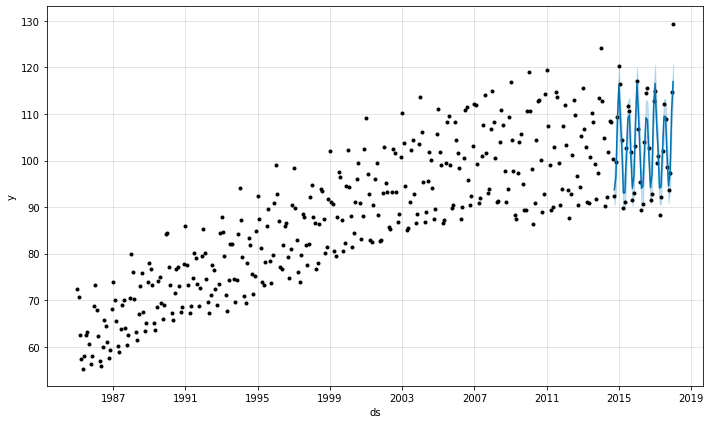

In [173]:
plt.figure(figsize=(18,5))
result.plot(predicted)

plt.show()

# Model Components plot

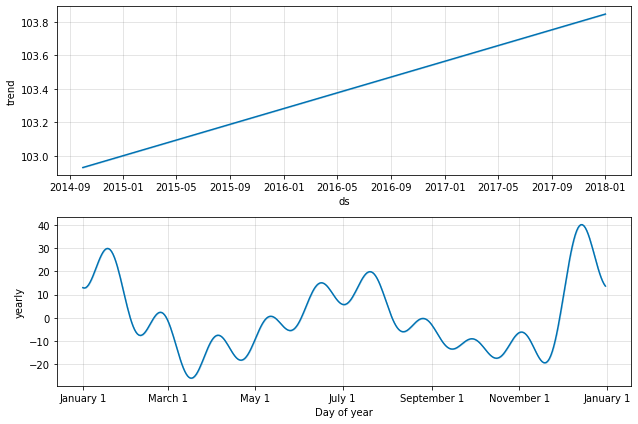

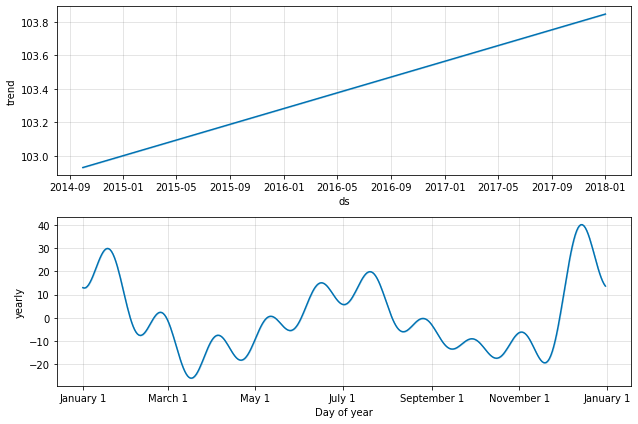

In [174]:
result.plot_components(predicted)

In [176]:
df_cv = cross_validation(model,initial = '730 days',period = '180 days',horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 61 forecasts with cutoffs between 1987-06-08 00:00:00 and 2017-01-01 00:00:00


  0%|          | 0/61 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


ds       yhat  yhat_lower  yhat_upper        y     cutoff
0 1987-07-01  71.549952   71.149868   71.931671  68.8694 1987-06-08
1 1987-08-01  69.357483   68.919266   69.757024  70.0669 1987-06-08
2 1987-09-01  66.187622   65.708786   66.662070  64.1151 1987-06-08
3 1987-10-01  64.659649   64.043603   65.252695  60.3789 1987-06-08
4 1987-11-01  67.700860   66.948685   68.414542  62.4643 1987-06-08

# Performance Metrics
In this, various error are computed across the data points to check the predicted result

In [180]:
df_p = performance_metrics(df_cv)
df_p.head()

horizon        mse      rmse       mae      mape     mdape  coverage
0 37 days  11.336738  3.367007  2.545309  0.028151  0.026345  0.561644
1 38 days  11.211366  3.348338  2.524928  0.027723  0.024723  0.561644
2 39 days  11.210532  3.348213  2.523622  0.027704  0.024723  0.561644
3 40 days  11.537820  3.396737  2.574640  0.028402  0.026345  0.554795
4 41 days  11.226375  3.350578  2.528437  0.027947  0.024723  0.561644

# Cross validation metric plot

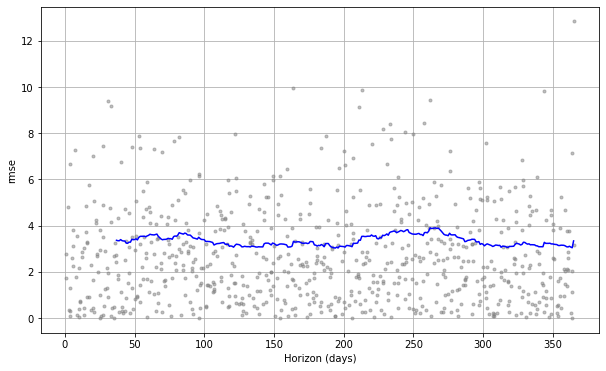

In [179]:
fig = plot_cross_validation_metric(df_cv,metric = 'rmse')



#### Creator: Jay Shimpi, Github: [Profile](https://github.com/JayShimpi22)